**Data Overview and Task**


Hourly rental data spanning two years was provided. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. The aim is to predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

Data Field Info

datetime - hourly date + timestamp

season - 1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

**Import Statements**


In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
import warnings
warnings.filterwarnings("ignore")

**Read Files**

In [120]:
train = pd.read_csv('train.csv')
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [121]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [122]:
test = pd.read_csv('test.csv')
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [123]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


**Data Cleaning**

Handle data format issues: datetime column

In [124]:
# Train dataset
train['datetime'] = pd.to_datetime(train['datetime'])
train['datetime'].dtypes

dtype('<M8[ns]')

In [125]:
# Test dataset
test['datetime'] = pd.to_datetime(test['datetime'])
test['datetime'].dtypes

dtype('<M8[ns]')

**Exploratory Data Analysis**

Explore training dataset

In [126]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


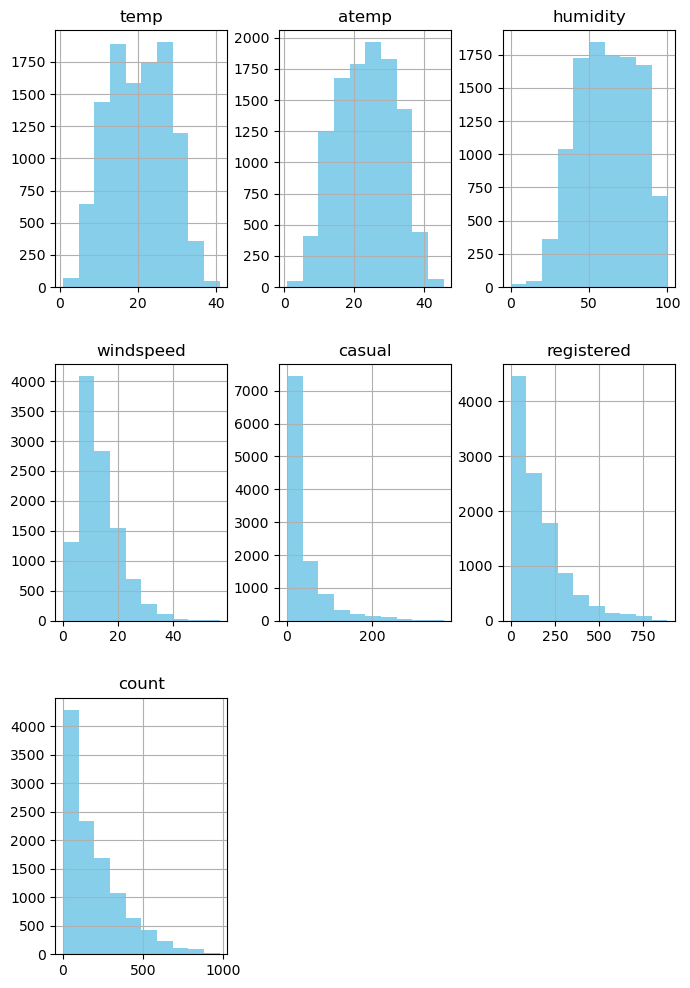

In [127]:
# Check the distribution of each column using a histogram
fig = plt.figure(figsize = (8,12))
ax = fig.gca()
train[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']].hist(ax=ax, color = "skyblue")
plt.show()

The temperature and feel-like temperature columns are normally distributed. The windspeed, casual, registered, and count columns are right-skewed while the humidity column is somewhat left-skewed. Let's further view the skewed columns using a box plot.

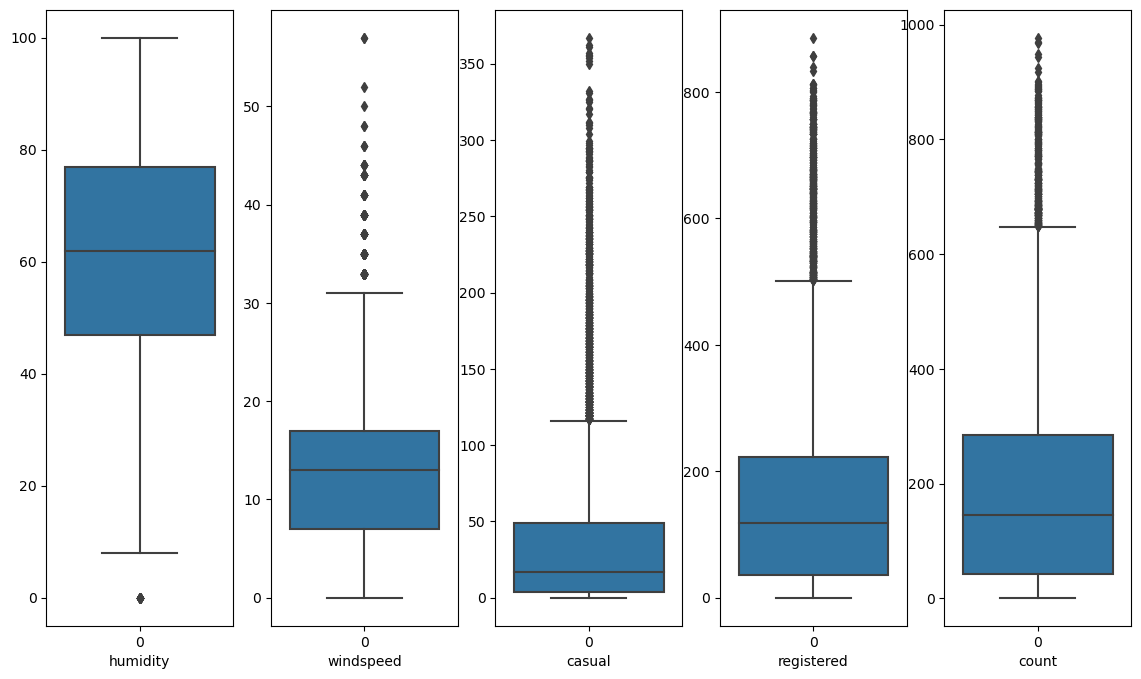

In [128]:
# Create a boxplot to check outliers
cols = ['humidity', 'windspeed', 'casual', 'registered', 'count']
ncols = len(cols)
fig, axes = plt.subplots(1, ncols, figsize=(14,8))
# use a for loop to create a boxplot for all the columns in the list above
for i in range(ncols):
    sns.boxplot(data=train[cols[i]], ax=axes[i])
    axes[i].set(xlabel=cols[i])

The boxplot does not show any outrageous outliers.

Now, let's do a deep dive on dataset before us. First, let's see the trend of dataset over the time period.

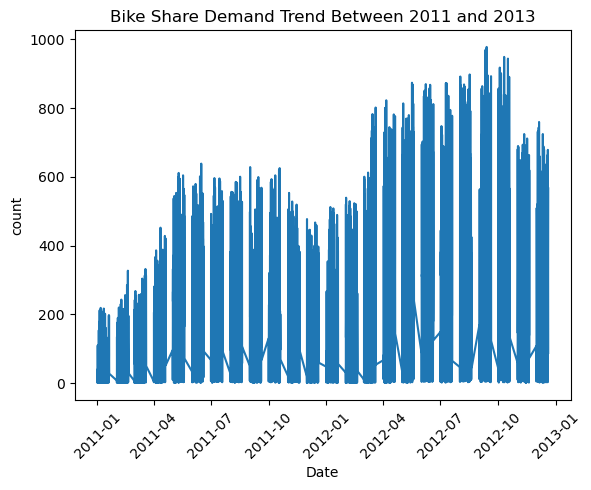

In [129]:
# Create lineplot 
ax = plt.subplot()
sns.lineplot(data=train, x='datetime', y='count',ax=ax)

# Set the labels and titles
plt.title('Bike Share Demand Trend Between 2011 and 2013')
plt.xticks(rotation=45)
plt.xlabel('Date')

# Show chart
plt.show()

From the chart above, the number of users peaks between the months of June - October. Let's confirm this trend by plotting a bar chart of the number of users per season.

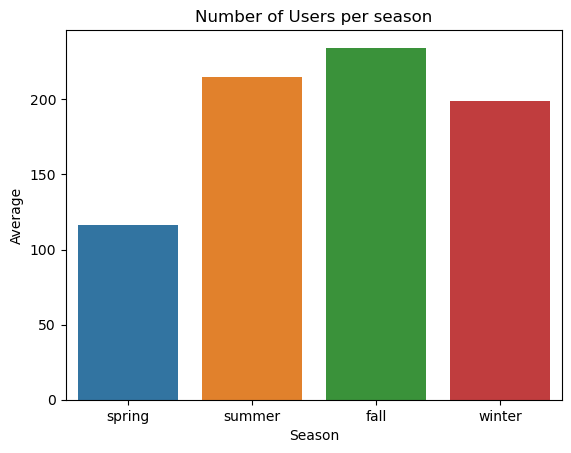

In [130]:
season = train.groupby('season')['count'].mean()
ax = plt.subplot()
sns.barplot(x=season.index, y=season.values,ax=ax)
plt.title('Number of Users per season')
plt.ylabel('Average')
plt.xlabel('Season')
labels = ['spring', 'summer', 'fall', 'winter']
ax.set_xticklabels(labels)
plt.show()

This confirms that the peak seasons are summer and fall with winter following closely behind. Could this be caused by climate?

Let's create a heatmap that will help us visualize the correlation between the various columns provided (especially columns related to the weather/climate) and the count column. 

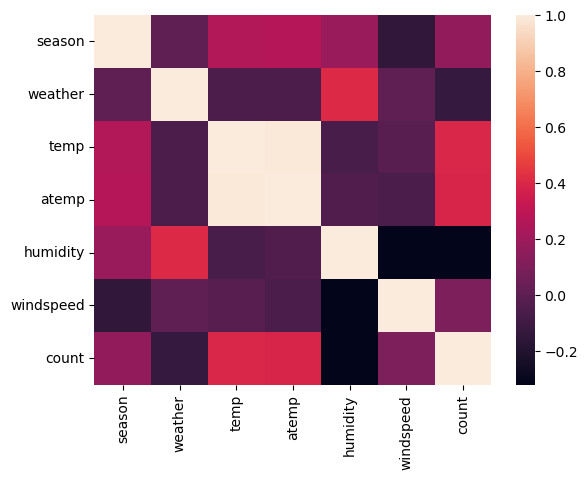

In [131]:
# Check correlation
climate = ['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count']
sns.heatmap(train[climate].corr());

From the chart above, the temperature and feel-like temperature are the most positively correlated weather-data to the count of users whereas the humidity column is the least correlated weather-data to the count of users. This implies that the warmer the weather, the higher the probability for a user to engage the bike share platform. Furthemore, the possibility of rainfall has a negative effect on the number of users engaging the platform.

As we have seen the relationship of the number of users with weather we should see its relationship with working days and non-working days

First, let's see the breakdown of our users to casual and registered users.

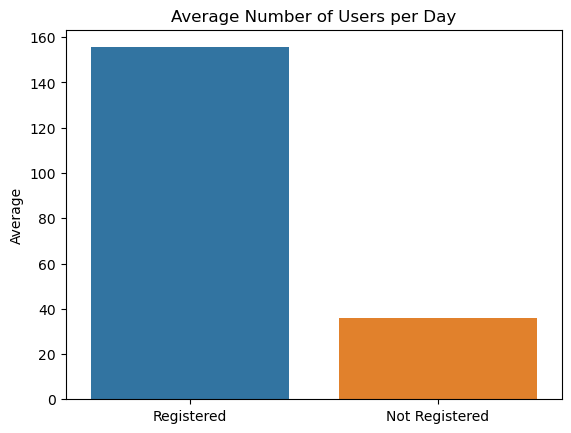

In [132]:
# calculate the average number of users per day for the casual and registered users
mean_users = [train['registered'].mean(), train['casual'].mean()]

# create a bar plot
labels = ['Registered', 'Not Registered']
ax = plt.subplot()
sns.barplot(x=labels, y=mean_users,ax=ax)

# create labels and title
plt.title('Average Number of Users per Day')
plt.ylabel('Average')

# show plot
plt.show()

The chart above clearly shows that on average, the registered members use the bike share platform more than casual members. 

Let's see if this trend continues for holidays and working days. First, we will check for all users then we will drilldown to registered and casual members.

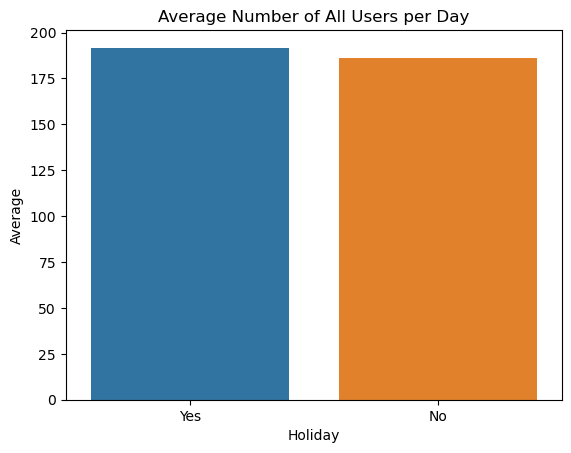

In [133]:
def create_barplot(groupby_col, mean_col, title, x_label):
    # create a mean of users 
    df = train.groupby(groupby_col)[mean_col].mean()

    # create bar plot
    ax = plt.subplot()
    sns.barplot(x=df.index, y=df.values,ax=ax)

    # add labels and titles
    plt.title(f'Average Number of {title} Users per Day')
    plt.ylabel('Average')
    plt.xlabel(f'{x_label}')
    labels = ['Yes', 'No']
    ax.set_xticklabels(labels)

    # show plot
    plt.show()

# create barplot for all users per day 
create_barplot('holiday', 'count', 'All', 'Holiday')

We have slightly more users on a holiday. Let's see if this is the case for registered users only.

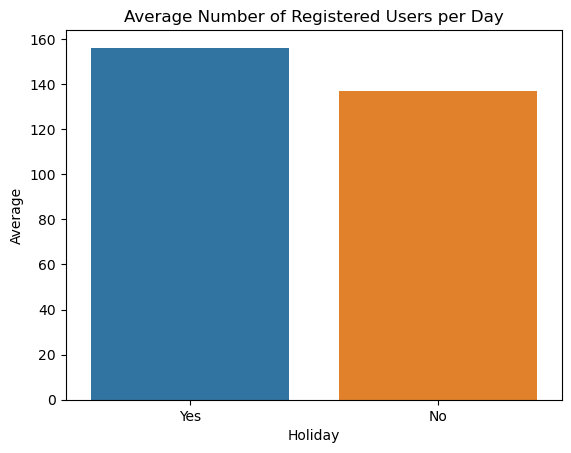

In [134]:
# create barplot for registered users per day 
create_barplot('holiday', 'registered', 'Registered', 'Holiday')

We clearly have more registered users on a holiday. How about casual users?

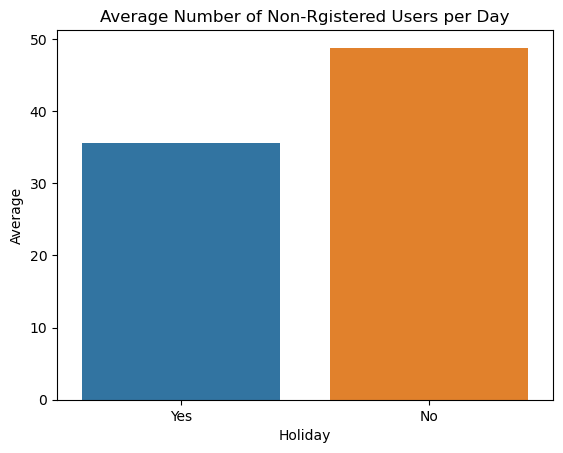

In [135]:
# create barplot for casual users per day 
create_barplot('holiday', 'casual', 'Non-Rgistered', 'Holiday')

The reverse is the case for non-registered users. We usually have fewer casual users on non-holidays.

Finally, let's undertake this analysis for working days i.e. weekdays and non-working days i.e. weekends (holidays inclusive). We will viisualize all users first before we drilldown to working and non-working days.

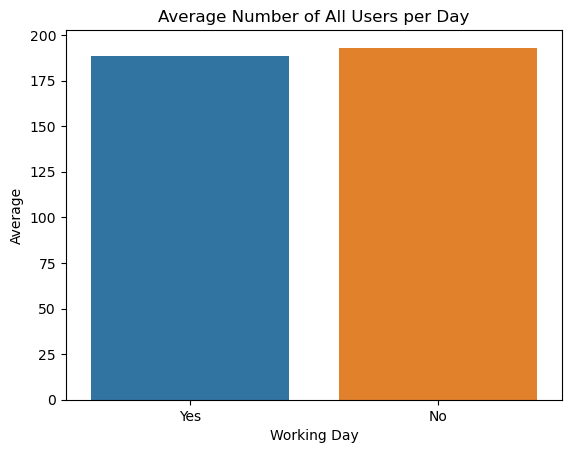

In [136]:
# create barplot for all users per day 
create_barplot('workingday', 'count', 'All', 'Working Day')

We have slightly more users on a non-working day than on a working day. Is this case for registered users?

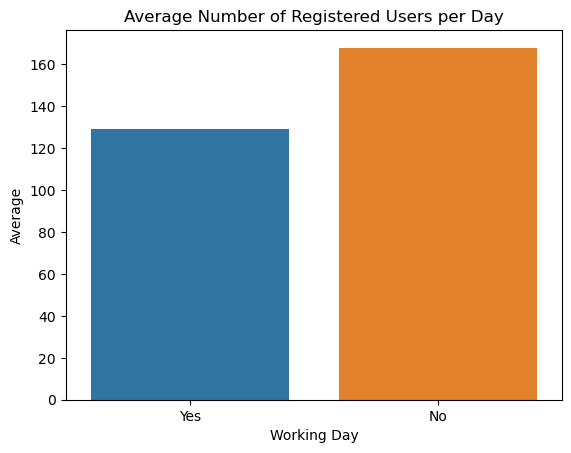

In [137]:
# create barplot for registered users per day 
create_barplot('workingday', 'registered', 'Registered', 'Working Day')

We clearly have more registered users engage the bike sharing platform on weekends and holidays. Let's see if this is the case for Casual Users.

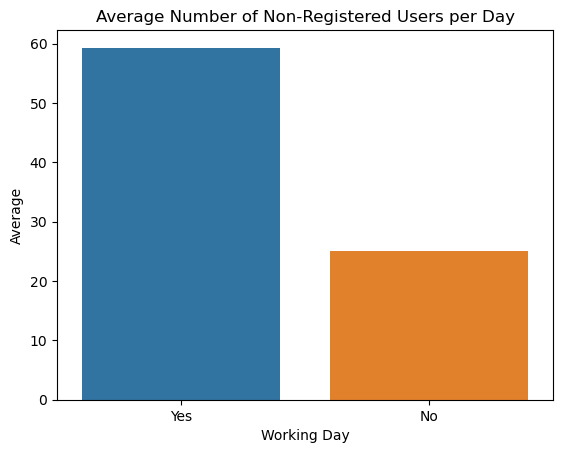

In [138]:
# create barplot for registered users per day 
create_barplot('workingday', 'casual', 'Non-Registered', 'Working Day')

Casual Users engage the platform more during working days.

As we have seen the monthly and daily trends, let's see the hourly trends and peak moments.

In [139]:
# Add seasonality variable
# training dataset
train['day'] = train['datetime'].dt.day
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour


In [140]:
# let's subset the hour column to six sessions
sessions = ['Late Night', 'Early Morning', 'Morning', 'Noon', 'Eve', 'Night']
bins = [0,4,8,12,16,20,24]
train['session'] = pd.cut(train['hour'], bins=bins, labels=sessions, include_lowest=True)

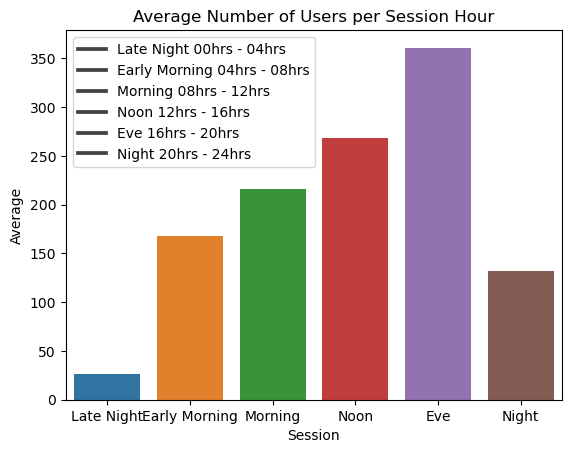

In [141]:
# create a mean of users 
session = train.groupby('session')['count'].mean()

# create bar plot
ax = plt.subplot()
sns.barplot(x=session.index, y=session.values,ax=ax)

# add labels and titles
plt.title(f'Average Number of Users per Session Hour')
plt.ylabel('Average')
plt.xlabel('Session')
(plt.legend(['Late Night 00hrs - 04hrs', 'Early Morning 04hrs - 08hrs', 'Morning 08hrs - 12hrs', 
             'Noon 12hrs - 16hrs', 'Eve 16hrs - 20hrs', 'Night 20hrs - 24hrs']))

# show plot
plt.show()

In [109]:
peak_hour = train.groupby('hour')['count'].mean()
peak_hour.sort_values(ascending=False)[:5]

hour
17    468.765351
18    430.859649
8     362.769231
16    316.372807
19    315.278509
Name: count, dtype: float64

From the chart and calculation above, the peak session is in the Evening between 16:00hrs and 20:00hrs with the peak hour being 17:00hrs.

**Model**

In [110]:
# split dataset horizontally train and validation
train_df = train[(train.day < 15)]
valid_df = train[(train.day >= 15)]

In [111]:
# Split dataset vertically x and y
# Training dataset
X_train = train_df.drop(['count', 'casual', 'registered', 'datetime', 'session'], axis=1)
y_train = train_df['count']

# Validation dataset
X_valid = valid_df.drop(['count', 'casual', 'registered', 'datetime', 'session'], axis=1)
y_valid = valid_df['count']

In [112]:
# Fit the model
rf = RandomForestRegressor(random_state=1)
rf.fit(X_train, y_train)

# predict
y_train_pred =  rf.predict(X_train)

In [113]:
# check accuracy
mean_squared_log_error(y_train, y_train_pred, squared=False)

0.18931068855542763

In [114]:
y_valid_pred = rf.predict(X_valid)
# check accuracy
mean_squared_log_error(y_valid, y_valid_pred, squared=False)

0.46157542587907086

We can now make predictions using our model and test data

In [21]:
# add seasonality to dataset
# testing dataset
test['day'] = test['datetime'].dt.day
test['month'] = test['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour

# Drop datetime column
tst = test.drop(['datetime'], axis=1)

In [ ]:
# Carry out walk-forward validation
predictions = []
history = train.copy()
history_x = (history.drop(['count', 'casual', 'registered', 'datetime', 'session'], axis=1))
history_y = (history['count'].values)
# test = test.drop(['datetime'], axis=1)
for i in range(len(tst)):
    # Fit the model
    rf = RandomForestRegressor(random_state=1)
    rf.fit(history_x, history_y)

    # predict
    pred =  rf.predict(tst[tst.index == i])
    
    # append newly predicted data to exisitng dataset    
    predictions.append(pred)
    history_x = history_x.append(tst[tst.index == i], ignore_index=True)
    history_y = np.append(history_y, pred)


In [57]:
# create a new dataframe containing date and predictions.
df_new = pd.DataFrame(predictions, columns=['Prediction'])
df_new['Datetime'] = test['datetime']
df_new

,Prediction,Datetime
0,14.230000,2011-01-20 00:00:00
1,6.040000,2011-01-20 01:00:00
2,6.500000,2011-01-20 02:00:00
3,3.760000,2011-01-20 03:00:00
4,3.008000,2011-01-20 04:00:00
...,...,...
6488,294.895766,2012-12-31 19:00:00
6489,188.443604,2012-12-31 20:00:00
6490,144.575081,2012-12-31 21:00:00
6491,100.562465,2012-12-31 22:00:00


In [58]:
# Save as csv
df_new.to_csv('Bike_Share_Demand.csv', index=False)